<a href="https://colab.research.google.com/github/lillanieder/data-projects/blob/main/3_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
!pip install pmdarima
!pip install sktime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 64.4 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 12.2 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':80})

import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import statsmodels.api as sm

from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sktime.utils.plotting import plot_series

from xgboost import XGBRegressor
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.base import ForecastingHorizon

# Data


In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/lillanieder/data-projects/main/data/forecasting.csv')
dt = pd.to_datetime(data['Year'].astype(str)  + data['Month'].astype(str),
                    format = '%Y%m')

df = data.copy()
df.index = pd.date_range(dt[0], periods = len(dt), freq = 'MS')

df = df[['Western European tractor industry >160 HP',
         'Wheat Price',
         'Milk Price EU',
         'CEMA Business Barometer Index (TR&HV)']]

# dropping last row due to null value
df = df[:-1]

# Time Series Analysis


## Trend and Seasonality

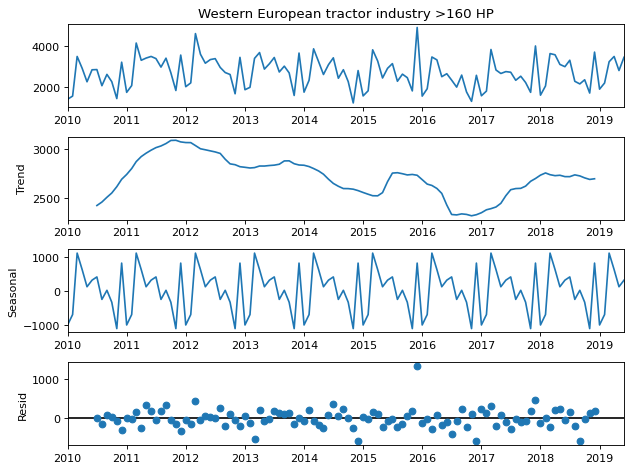

In [4]:
res = seasonal_decompose(df['Western European tractor industry >160 HP'])
fig = res.plot()

## Stationarity: Augmented Dickey–Fuller Test

In [5]:
targets = [df['Western European tractor industry >160 HP'],
           df['Western European tractor industry >160 HP'].diff()[1:],
           df['Western European tractor industry >160 HP'].diff().diff()[2:]]

for i, t in enumerate(targets):
  result = adfuller(t)
  if i==0:
    print('Original data')
  if i==1:
    print('First differencing')
  if i==2:
    print('Second differencing')
  
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Original data
ADF Statistic: -2.209556
p-value: 0.202795
Critical Values:
	1%: -3.498
	5%: -2.891
	10%: -2.582
First differencing
ADF Statistic: -3.804712
p-value: 0.002859
Critical Values:
	1%: -3.498
	5%: -2.891
	10%: -2.582
Second differencing
ADF Statistic: -7.606567
p-value: 0.000000
Critical Values:
	1%: -3.499
	5%: -2.892
	10%: -2.583


# Modeling

In [6]:
train_tf_start = '2010-01'
train_tf_end = '2018-06'
test_tf_start = '2018-07'

## SARIMA: Seasonal ARIMA

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1392.973, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1318.781, Time=0.41 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1368.986, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1310.817, Time=0.95 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=1309.876, Time=4.18 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1308.147, Time=1.18 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.64 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=4.75 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=1309.557, Time=2.74 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=7.84 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1330.221, Time=1.33 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=1305.802, Time=2.63 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=inf, Time=2.15 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1

(<Figure size 1280x320 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fea794bda30>)

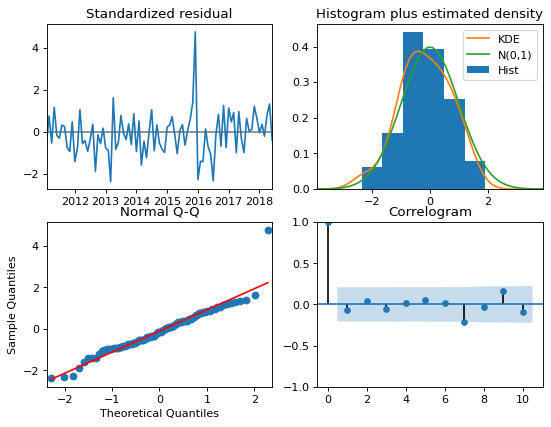

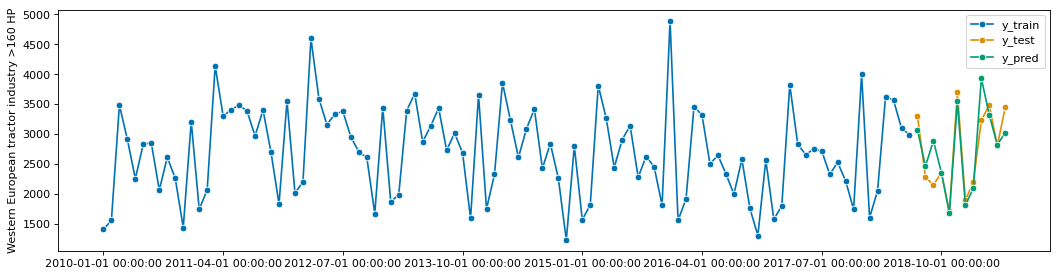

In [7]:
# data
y_train = df.loc[train_tf_start:train_tf_end]['Western European tractor industry >160 HP']
y_test = df.loc[test_tf_start:]['Western European tractor industry >160 HP']

# model
model = pm.auto_arima(y_train, 
                      start_p=0, max_p=3, start_q=0, max_q=3, d=1,
                      start_P=0, start_Q=0, D=1,
                      seasonal=True, m=12,
                      trace=True,
                      error_action='ignore',
                      random_state = 1
                      )
model.fit(y_train)

# model stat
fig = model.plot_diagnostics()

# pred
y_pred = model.predict(n_periods=len(y_test))

# eval
print('MAPE: %.4f' % mean_absolute_percentage_error(y_test, y_pred))
print('R2: %.4f' % r2_score(y_test, y_pred))
plot_series(y_train, y_test, y_pred, labels = ["y_train", "y_test", "y_pred"])

## SARIMAX: SARIMA with exogenous factors

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                           SARIMAX Results                                           
Dep. Variable:     Western European tractor industry >160 HP   No. Observations:                  102
Model:                        SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -642.761
Date:                                       Wed, 15 Feb 2023   AIC                           1299.522
Time:                                               18:53:20   BIC                           1316.943
Sample:                                           01-01-2010   HQIC                          1306.544
                                                - 06-01-2018                                         
Covariance Type:                                         opg                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

(<Figure size 1280x320 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fea79323610>)

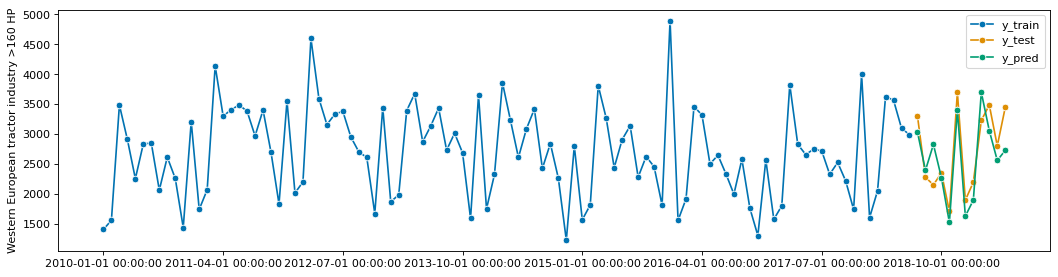

In [8]:
# data
y_train = df.loc[train_tf_start:train_tf_end]['Western European tractor industry >160 HP']
y_test = df.loc[test_tf_start:]['Western European tractor industry >160 HP']

exog_cols = ['Wheat Price', 'Milk Price EU', 'CEMA Business Barometer Index (TR&HV)']
exog_train = df.loc[train_tf_start:train_tf_end][exog_cols]
exog_test = df.loc[test_tf_start:][exog_cols]

# model
exog_model = sm.tsa.statespace.SARIMAX(endog = y_train,
                                       exog = exog_train,
                                       order = model.order,
                                       seasonal_order = model.seasonal_order)\
                                       .fit()
# model stat
print(exog_model.summary())

# pred
y_pred = exog_model.forecast(steps=len(y_test), exog = exog_test)

# eval
print('MAPE: %.4f' % mean_absolute_percentage_error(y_test, y_pred))
print('R2: %.4f' % r2_score(y_test, y_pred))
plot_series(y_train, y_test, y_pred, labels = ["y_train", "y_test", "y_pred"])

## XGBRegressor

MAPE: 0.0984
R2: 0.7649


(<Figure size 1280x320 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fea7fae7bb0>)

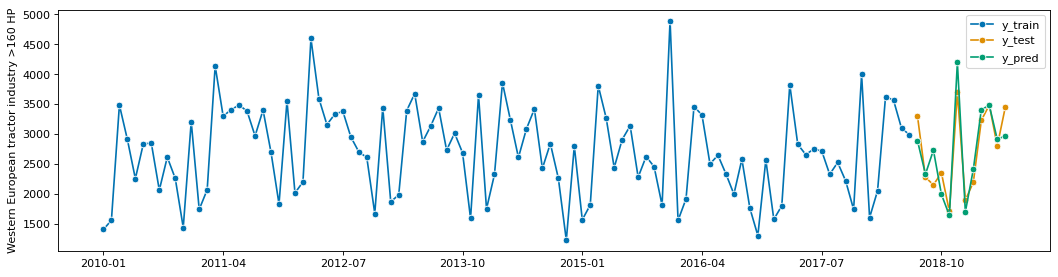

In [9]:
# data
X = df.copy()
X.index = pd.PeriodIndex(X.index, freq = "M")

y_train = X.loc[train_tf_start:train_tf_end]['Western European tractor industry >160 HP']
y_test = X.loc[test_tf_start:]['Western European tractor industry >160 HP']

# model
regressor = XGBRegressor(objective = 'reg:squarederror', random_state = 1)
forecaster = make_reduction(regressor, window_length = 12, strategy = "recursive")
fh = ForecastingHorizon(y_test.index, is_relative = False)
forecaster.fit(y_train)

# pred
y_pred = forecaster.predict(fh = fh)

# eval
print('MAPE: %.4f' % mean_absolute_percentage_error(y_test, y_pred))
print('R2: %.4f' % r2_score(y_test, y_pred))
plot_series(y_train, y_test, y_pred, labels = ["y_train", "y_test", "y_pred"])